
## Machine Learning Assisted College Advising
Every year millions of high school students enroll in college.  About a third of these students will not graduate.  Droping out of college is a demoralizing and expensive way to start adulthood.  
The objective of this study is to build a model predicting the likelihood of college graduation for a student in high school, using data known about the student at the time of college enrollment.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#import functions as fx
% matplotlib inline
import plotly
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split

from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
import imblearn

from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn import metrics
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import auc, precision_recall_curve

pd.set_option('display.max_columns', None)

###  The Data
The following is a list of features to keep from the educational longitudinal study of 2002.
This study followed about 16000 people over ten year period starting in their sophmore year in high school.  The first follow up is in the student's senior year of high school, a second follow up two years after high school graduation and the third follow in 2012, or at about the age 26.   The entire dataset has about 5000 features made up of information collected from questionaires, academic performance data supplied by the school, and other means of collection.  Much of this data is restricted in the public release version of the study.  From the publically available data I have chosen 31 features. 
My analysis takes data from the base year and the first follow collections. These collection points correspond the the students sophmore and senior year of high school.  These data provide a snapshot of the student at the point just before enrollment in college. The college outcome data comes from the third follow up.  This data is the target of the modelling and predicting these outcomes is the objective of this study.<br> 
A more extensive review of the features included below can be found in the markdown file 'features.md' in the github repository.
Link to the online codebook:  https://nces.ed.gov/OnlineCodebook/Session/Codebook/464e26ac-050e-4cc2-9347-1297cf285b4f.

In [2]:
columns = ['BYHOMLIT','BYRISKFC','BYOCC30',
          'BYTXMSTD','BYTXRSTD','BYMATHSE','BYENGLSE','BYWRTNGA','BYHMWRK',
          'BYTVVIGM','BYWRKHRS', 'BYNSPORT','BYXTRACU','F1STEXP','F1OCC30',
           'F1TXMSTD','F1HIMATH','F1PSEPLN','F1RGPP2','F1XTRACU','F1WRKHRS',
           'F1TVVIGM','F1MATHSE','F1RHTUNP','F3EVRATT','F3PS1LVL','F3PSLCRED',
           'F3PS2BA','F3ATTAINMENT','F3F1EDEXPFF','F3ERN2011']

In [3]:
df = pd.read_csv('../els_02_12_byf3pststu_v1_0.csv',
                 usecols = columns)

renaming columns

In [4]:
df.head(1)

,BYHOMLIT,BYRISKFC,BYOCC30,BYTXMSTD,BYTXRSTD,BYMATHSE,BYENGLSE,BYWRTNGA,BYNSPORT,BYXTRACU,BYHMWRK,BYTVVIGM,BYWRKHRS,F1STEXP,F1OCC30,F1TXMSTD,F1HIMATH,F1PSEPLN,F1XTRACU,F1WRKHRS,F1TVVIGM,F1MATHSE,F1RHTUNP,F1RGPP2,F3EVRATT,F3PS1LVL,F3PSLCRED,F3PS2BA,F3ATTAINMENT,F3F1EDEXPFF,F3ERN2011
0,0,2,-1,52.11,59.53,-1.118,-0.633,1.191,0,1,7,99,6,3,7,49.6,5,2,1,6,3,-0.258,31,2,1,2,0,-3,3,1,4000


Now to change the names of the columnns to something more comprehensible

In [5]:
def rename_cols(df):
    rename_list = ['literacy_home','risk_factors','aspired_occ_b','math_b',
                    'reading_b','math_conf_b','verbal_confidence','writing','sports','by_xcurr',
                    'homework','hedonics_b','hours_working_b','edu_confidence',
                    'aspired_occ_1','math_1','math_status_1','ps_step_1','f1_xcurr','hours_working_1',
                    'hedonics_1','math_conf_1','hs_ac_load','hs_gpa','any_ps','ps_level','graduated_Y',
                    'time_to_grad','edu_achievment','expected_edu','wages_yr']
    df.columns = rename_list
    return df

Going forward the dataset will look like this:

In [6]:
rename_cols(df).head(1)

,literacy_home,risk_factors,aspired_occ_b,math_b,reading_b,math_conf_b,verbal_confidence,writing,sports,by_xcurr,homework,hedonics_b,hours_working_b,edu_confidence,aspired_occ_1,math_1,math_status_1,ps_step_1,f1_xcurr,hours_working_1,hedonics_1,math_conf_1,hs_ac_load,hs_gpa,any_ps,ps_level,graduated_Y,time_to_grad,edu_achievment,expected_edu,wages_yr
0,0,2,-1,52.11,59.53,-1.118,-0.633,1.191,0,1,7,99,6,3,7,49.6,5,2,1,6,3,-0.258,31,2,1,2,0,-3,3,1,4000


In [7]:
df.shape

(16197, 31)

I am calling this dataset 'lost'.  As i will demonstrate in few cells they are dispropotionally dropping out of education and earning significantly less than thier peers.  This study neglects these individuals.  Instead I focus on students seeking post-secondary education.  

In [8]:
lost = df[df.ps_level < 0]

This dataset is 'ps' for post-secondary.  This cohort of the dataset has made some attempt to gain some kind of post secondary credential and has data from standardized testing.

In [9]:
ps = df[(df.math_1 > 0)
        &(df.math_b > 0)
        &(df.reading_b > 0)
        & (df.ps_level >= 0)
        &(df.graduated_Y >=0)]

In [10]:
print(lost[lost.wages_yr < 0].shape)

(2947, 31)


'2947' is the number of null values in this feature for the 'lost' cohort.  A significant fraction of the 'lost' group have not responded to the third follow up questionaire and while the 'ps' dataset, as I have curated it, have such data.  Suffice to say that the means are significantly depressed for 'lost' vs. 'ps' in important categories.  The purpose of this diversion is to justify why I am neglecting this data as the analysis continues.  While this category of 'lost' students represent a segment of the population that is worthy of study and have important social consequences, this analysis focuses on those that for whatever reasons have the combination of motivation and ability to pursue post secondary education based on what the data can support. 

In [11]:
#finding average value of standardized testing
print(f'base year reading score mean of whole dataset:  {round(df.reading_b.mean())}')
print(f'base year math score mean of whole dateset:  {round(df.math_b.mean())} \n')

#standard deviations of standardized testing
print(f'standard deviation of base year reading score for whole dataset:  {round(df.reading_b.std())}')
print(f'standard deviation of base year math score for whole dataset:  {round(df.math_b.std())} \n')

#standardized testing for 'lost' group
print(f'base year reading score mean of lost:  {round(lost.reading_b.mean())}')
print(f'base year math score mean of lost:  {round(lost.math_b.mean())} \n')

#standardized testing of post-secondary, or 'ps' group
print(f'base year reading score mean of ps:  {round(ps.reading_b.mean())}')
print(f'base year math score mean of ps:  {round(ps.math_b.mean())}\n')

#wages of the two categories
print(f'null wages of lost: {lost[lost.wages_yr < 0].shape}')
print(f'mean wages of \'lost\': {round(lost.wages_yr.mean())}\n')

print(f'null wages of ps: {ps[ps.wages_yr < 0].shape}')
print(f'mean wages of \'ps\':  {round(ps.wages_yr.mean())}')

base year reading score mean of whole dataset:  49.0
base year math score mean of whole dateset:  50.0 

standard deviation of base year reading score for whole dataset:  13.0
standard deviation of base year math score for whole dataset:  13.0 

base year reading score mean of lost:  44.0
base year math score mean of lost:  44.0 

base year reading score mean of ps:  53.0
base year math score mean of ps:  53.0

null wages of lost: (2947, 31)
mean wages of 'lost': 7933.0

null wages of ps: (0, 31)
mean wages of 'ps':  27801.0


From here the analysis will be on a version the 'ps' category as i have defined it.   That is to say, the subset of the data that have pursued post-secondary education and have meaningful data regarding standardized test scores,level of post-secondary education, and graduation

### The Post-Secondary Cohort

reading in the data again to eliminate study defined NaN values

In [12]:
df_2 = pd.read_csv('../els_02_12_byf3pststu_v1_0.csv',
                 usecols = columns,
                 na_values = [-9,-8,-4, -7,-3, 97, 98, 99])

In [13]:
rename_cols(df_2)

,literacy_home,risk_factors,aspired_occ_b,math_b,reading_b,math_conf_b,verbal_confidence,writing,sports,by_xcurr,homework,hedonics_b,hours_working_b,edu_confidence,aspired_occ_1,math_1,math_status_1,ps_step_1,f1_xcurr,hours_working_1,hedonics_1,math_conf_1,hs_ac_load,hs_gpa,any_ps,ps_level,graduated_Y,time_to_grad,edu_achievment,expected_edu,wages_yr
0,0.0,2.0,-1.0,52.11,59.53,-1.118,-0.633,1.191,0.0,1.0,7.0,NaN,6.0,3.0,7.0,49.60,5.0,2.0,1.0,6.0,3.0,-0.258,31.0,2.0,1.0,2.0,0.0,NaN,3.0,1.0,4000.0
1,3.0,0.0,9.0,57.65,56.70,1.533,0.331,1.191,0.0,3.0,5.0,4.0,0.0,8.0,10.0,60.64,6.0,5.0,2.0,1.0,2.0,0.528,31.0,4.0,1.0,1.0,1.0,44.0,10.0,2.0,3000.0
2,2.0,NaN,10.0,66.44,64.46,-0.154,-0.933,0.996,0.0,2.0,NaN,1.0,0.0,6.0,NaN,64.26,6.0,5.0,2.0,0.0,2.0,-0.215,30.0,4.0,1.0,1.0,1.0,45.0,6.0,2.0,37000.0
3,1.0,NaN,10.0,44.68,48.69,1.030,1.146,-0.137,1.0,0.0,11.0,NaN,0.0,6.0,-1.0,45.59,4.0,4.0,1.0,5.0,NaN,0.238,32.0,4.0,1.0,2.0,0.0,NaN,4.0,3.0,1500.0
4,1.0,2.0,16.0,40.57,33.53,0.121,0.143,-0.435,0.0,0.0,10.0,4.0,3.0,7.0,16.0,38.79,5.0,5.0,0.0,6.0,1.0,1.024,32.0,4.0,1.0,2.0,0.0,NaN,4.0,3.0,48000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16192,1.0,NaN,15.0,32.98,44.62,-0.118,-0.372,NaN,1.0,0.0,4.0,2.0,7.0,6.0,-1.0,NaN,6.0,5.0,2.0,7.0,NaN,NaN,24.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16193,1.0,5.0,-1.0,35.91,33.78,-0.381,-0.207,NaN,1.0,1.0,6.0,3.0,0.0,4.0,NaN,34.57,5.0,3.0,3.0,8.0,5.0,0.577,16.0,3.0,0.0,NaN,NaN,NaN,1.0,3.0,7000.0
16194,3.0,3.0,-1.0,36.85,40.56,-0.355,-1.122,NaN,0.0,0.0,4.0,NaN,0.0,8.0,-1.0,NaN,6.0,NaN,NaN,8.0,1.0,NaN,6.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16195,2.0,4.0,-1.0,48.87,43.51,0.068,-0.118,NaN,0.0,1.0,25.0,5.0,4.0,5.0,-1.0,NaN,5.0,6.0,1.0,5.0,4.0,NaN,23.0,5.0,1.0,2.0,0.0,NaN,4.0,5.0,20000.0


In [14]:
ps = df_2[(df_2.math_1 > 0) 
        & (df_2.math_b > 0)
        & (df_2.reading_b > 0)
        &  (df_2.ps_level >= 0)
        & (df_2.graduated_Y >=0)]

In [15]:
ps.hs_gpa.value_counts()

5.0    2473
6.0    2286
4.0    2113
3.0    1532
2.0     671
1.0     161
0.0      33
Name: hs_gpa, dtype: int64

for 'hs_gpa' value counts over '6' are NaN.  I handle this feature separately because integers greater than '6' occur as legitimate values in other features and i don't want alter them.

In [16]:
ps.loc[ps.hs_gpa > 6] = np.NaN

/Users/eonjamesslemp/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/eonjamesslemp/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



out of about 99000 rows 632 have null values here.  

In [17]:
ps.hs_gpa.isnull().sum()

632

### Feature Engineering
The remaing data contains 9901 observations.  The next cell builds out some new features composed of original features that i hope will be relevant to modeling and interpretation.
These constructs are:<br>
**effort** - Home work times high school academic load.  With this construct I am hoping to capture some information to time and energy devoted to academic pursuit <br>
**'testing'** - the sum of the reading and two math standardized tests.<br>
**v_facility** - reading score scaled by the home literacy environment as defined by the study plus 1.  Incrementing by 1 keeps the metric from becoming zero when 'home literacy environment' is zero.<br>
**m_facility** - math standardized test scores scaled by the highest completed math class as defined by the study.<br>
**academic_P** - the 'effort' construct, scaled by the high school GPA feature.  <br>
**iq_by_concientiousness** - possibly controversial, but verbal and math facility as defined by the previous metrics scaled by the sum of the total number of academic classes taken in high school plus the estimated number of homework hours per week.  I hope this feature captures information on intelligence from the standardized tests and commitment to education as demonstrated by the data available.<br>
**delinquency** - risk factors in the students life as defined by the study scaling the number of hours per week spent spent on tv/videogames/movies in the base year and first follow up.<br>
**wages_cont** - trying to approximate wages continiously as the data in the original study stratifies wage information past 100K.  This leads to difficult to interpret visualizations.  The intent here is to use the fact that income tends to be positively correlated to IQ metrics to circumvent the study imposed stratification

In [18]:
def add_cool_features(df):
    df.loc[:,'effort'] = (df.homework*df.hs_ac_load)
    df.loc[:,'testing'] = df.math_b+df.reading_b+df.math_1
    df.loc[:,'v_facility'] = df.reading_b*(df.literacy_home + 1)
    df.loc[:,'m_facility'] = df.math_status_1*df.math_1
    df.loc[:,'academic_p'] = (df.effort)*df.hs_gpa
    df.loc[:,'iq_by_concientiousness'] = (df.v_facility+df.m_facility)*(df.homework+df.hs_ac_load)
    df.loc[:,'delinquency'] = df.risk_factors*(df.hedonics_b + df.hedonics_1)
    #df['effort'] = (df.homework+df.hs_ac_load)
    df.loc[:,'wages_cont'] = df.testing*df.wages_yr
    return df

In [19]:
add_cool_features(ps).head()

/Users/eonjamesslemp/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/eonjamesslemp/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/pandas/core/indexing.py:576: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,literacy_home,risk_factors,aspired_occ_b,math_b,reading_b,math_conf_b,verbal_confidence,writing,sports,by_xcurr,homework,hedonics_b,hours_working_b,edu_confidence,aspired_occ_1,math_1,math_status_1,ps_step_1,f1_xcurr,hours_working_1,hedonics_1,math_conf_1,hs_ac_load,hs_gpa,any_ps,ps_level,graduated_Y,time_to_grad,edu_achievment,expected_edu,wages_yr,effort,testing,v_facility,m_facility,academic_p,iq_by_concientiousness,delinquency,wages_cont
0,0.0,2.0,-1.0,52.11,59.53,-1.118,-0.633,1.191,0.0,1.0,7.0,NaN,6.0,3.0,7.0,49.60,5.0,2.0,1.0,6.0,3.0,-0.258,31.0,2.0,1.0,2.0,0.0,NaN,3.0,1.0,4000.0,217.0,161.24,59.53,248.00,434.0,11686.14,NaN,644960.0
1,3.0,0.0,9.0,57.65,56.70,1.533,0.331,1.191,0.0,3.0,5.0,4.0,0.0,8.0,10.0,60.64,6.0,5.0,2.0,1.0,2.0,0.528,31.0,4.0,1.0,1.0,1.0,44.0,10.0,2.0,3000.0,155.0,174.99,226.80,363.84,620.0,21263.04,0.0,524970.0
2,2.0,NaN,10.0,66.44,64.46,-0.154,-0.933,0.996,0.0,2.0,NaN,1.0,0.0,6.0,NaN,64.26,6.0,5.0,2.0,0.0,2.0,-0.215,30.0,4.0,1.0,1.0,1.0,45.0,6.0,2.0,37000.0,NaN,195.16,193.38,385.56,NaN,NaN,NaN,7220920.0
3,1.0,NaN,10.0,44.68,48.69,1.030,1.146,-0.137,1.0,0.0,11.0,NaN,0.0,6.0,-1.0,45.59,4.0,4.0,1.0,5.0,NaN,0.238,32.0,4.0,1.0,2.0,0.0,NaN,4.0,3.0,1500.0,352.0,138.96,97.38,182.36,1408.0,12028.82,NaN,208440.0
4,1.0,2.0,16.0,40.57,33.53,0.121,0.143,-0.435,0.0,0.0,10.0,4.0,3.0,7.0,16.0,38.79,5.0,5.0,0.0,6.0,1.0,1.024,32.0,4.0,1.0,2.0,0.0,NaN,4.0,3.0,48000.0,320.0,112.89,67.06,193.95,1280.0,10962.42,10.0,5418720.0


function to drop selected columns

In [20]:
drop_list = ['any_ps','ps_step_1', 'wages_yr',
            'time_to_grad','edu_achievment','expected_edu']
def drop_stuff(df, l):
    #dropping selected columns
    for i in l:
        df.drop(i, axis = 1, inplace = True)
    return df

Dropping some features that I included, as they may be relevant for a follow up portion of the project, but at this point, would corrupt the modeling. 
Columns dropped are:  'any_ps', 'ps_level', 'id','ps_step_1', 'time_to_grad', 'edu_achievment', 'expected_edu'.
These features give information either directly or indirectly related to college completion that would not be know at the time of the first follow up. 

In [21]:
ps_dropped = drop_stuff(ps,drop_list)

/Users/eonjamesslemp/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/pandas/core/frame.py:4117: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [22]:
def x_y_split(df):    
    #splits target from data
    x = df.iloc[:,(df.columns!='graduated_Y')]
    y = df.graduated_Y
    
    #creates test train split
    X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=4, test_size=0.2)
    
    #rejoins target to dataset 
    test = pd.concat([X_test, y_test], axis = 1)
    train = pd.concat([X_train, y_train], axis = 1)
    
    return train, test

function train test splitting rejoining the target

In [23]:
college_train, college_test = x_y_split(ps_dropped)

Doing a train test split here so that i can impute missing values of the train and test splits separately

In [24]:
print("Training set shape: ", college_train.shape)
print("Test set shape: ", college_test.shape)

Training set shape:  (7920, 33)
Test set shape:  (1981, 33)


In [25]:
def KNNimpute_DF(df):
    #filling in missing values with knn imputer
    imputer_knn = KNNImputer(n_neighbors = 10)
    imputer_knn.fit(df)

    x = imputer_knn.transform(df)
    
    #casting the numpy array to dataframe
    df = pd.DataFrame(x)
    return df

Imputing missing values.

In [26]:
imputed_coll_train = KNNimpute_DF(college_train)

In [27]:
def rename_cols_x(df):
    rename_list = college_train.columns
    df.columns = rename_list
    return df

renaming columns after imputation

In [28]:
train_college_imp = rename_cols_x(imputed_coll_train)

In [29]:
def round_ordinals(x):
    ordinal_feature_list = ['literacy_home','risk_factors','aspired_occ_b','sports','by_xcurr',
                    'homework','hedonics_b','hours_working_b','edu_confidence',
                    'aspired_occ_1','math_status_1','hs_gpa','f1_xcurr','hours_working_1',
                    'hedonics_1','hs_ac_load', 'testing','academic_p','graduated_Y']
    
    for k in ordinal_feature_list:
        x[k] = x.loc[:,k].apply(round)
    return x

Rounding ordinal and categorical features to reassert integer status for those features made that were made decimal during imputation

In [30]:
round_ordinals(train_college_imp)

,literacy_home,risk_factors,aspired_occ_b,math_b,reading_b,math_conf_b,verbal_confidence,writing,sports,by_xcurr,homework,hedonics_b,hours_working_b,edu_confidence,aspired_occ_1,math_1,math_status_1,f1_xcurr,hours_working_1,hedonics_1,math_conf_1,hs_ac_load,hs_gpa,ps_level,effort,testing,v_facility,m_facility,academic_p,iq_by_concientiousness,delinquency,wages_cont,graduated_Y
0,3,1,10,64.65,65.70,0.7487,0.5229,0.0520,0,1,10,1,0,7,-1,65.65,6,3,3,1,0.9824,32,6,1.0,320.0,196,262.80,393.90,1920,27581.400,2.0,0.0,1
1,3,0,9,63.74,64.71,0.3600,0.6660,1.0010,2,2,27,5,0,7,9,60.59,5,3,1,1,0.7460,24,6,1.0,648.0,189,258.84,302.95,3888,28651.290,3.1,8884880.0,1
2,2,0,-1,40.50,46.23,-0.1830,0.0780,-0.1370,2,0,11,2,0,6,-1,42.39,5,2,0,3,0.4950,24,4,1.0,264.0,129,138.69,211.95,1056,12272.400,0.0,90384.0,1
3,2,1,10,59.68,51.03,0.7810,-1.1940,0.0520,0,2,8,1,0,8,10,63.61,6,3,4,2,0.4950,28,6,1.0,224.0,174,153.09,381.66,1344,19251.000,3.0,14817200.0,0
4,2,2,10,55.44,61.51,0.0139,0.1298,0.0520,0,1,13,2,1,9,10,46.34,4,6,2,3,-1.2800,21,3,1.0,273.0,163,162.56,185.36,819,14068.011,10.0,4245540.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7915,0,2,10,48.97,39.82,-1.8310,-1.9050,-0.8980,0,0,2,3,0,6,-1,48.69,4,1,5,1,-0.8084,24,4,2.0,48.0,137,39.82,194.76,192,6099.080,12.5,13748.0,1
7916,2,0,9,62.47,61.26,1.3220,0.3310,0.3100,0,1,8,8,0,7,11,56.32,5,3,1,2,1.0240,15,4,1.0,120.0,180,183.78,281.60,480,10703.740,2.6,5221450.0,0
7917,1,1,2,60.06,55.22,-0.6300,-0.1260,0.1600,1,1,9,3,1,7,9,49.98,5,2,2,5,-0.5100,27,5,1.0,243.0,165,110.44,249.90,1215,12972.240,6.5,8758780.0,0
7918,2,0,-1,50.40,48.81,-0.1540,-0.9330,0.3531,1,1,12,4,0,6,9,44.59,6,5,1,3,0.0014,28,5,1.0,336.0,144,146.43,267.54,1680,16558.800,5.2,3595000.0,1


In [31]:
train_college_imp = pd.get_dummies(train_college_imp,
            columns = ['aspired_occ_b','aspired_occ_1'])

Preparing test set along same lines as train set.

In [32]:
imputed_coll_test = KNNimpute_DF(college_test)

test_college_imp = rename_cols_x(imputed_coll_test)

round_ordinals(test_college_imp)

,literacy_home,risk_factors,aspired_occ_b,math_b,reading_b,math_conf_b,verbal_confidence,writing,sports,by_xcurr,homework,hedonics_b,hours_working_b,edu_confidence,aspired_occ_1,math_1,math_status_1,f1_xcurr,hours_working_1,hedonics_1,math_conf_1,hs_ac_load,hs_gpa,ps_level,effort,testing,v_facility,m_facility,academic_p,iq_by_concientiousness,delinquency,wages_cont,graduated_Y
0,3,1,10,61.29,66.44,1.7720,1.5960,1.951,2,3,2,1,0,8,10,63.02,6,5,0,1,1.3020,26,6,1.0,52.0,191,265.760,378.12,312,18028.640,4.7,2670500.0,1
1,2,1,10,52.98,56.70,-1.1060,0.3310,1.001,1,1,13,3,0,6,9,51.00,5,6,8,2,-0.2590,28,5,1.0,364.0,161,170.100,255.00,1820,17429.100,5.0,0.0,0
2,2,1,9,41.14,41.79,0.3330,-1.1940,-0.703,0,0,2,4,0,3,-1,43.86,5,1,0,2,-0.3042,21,4,1.0,42.0,127,125.370,219.30,168,7927.410,6.0,0.0,0
3,3,0,-1,69.05,67.17,1.7720,1.5960,1.951,1,1,10,3,0,6,-1,71.56,6,4,0,2,1.8110,26,6,1.0,260.0,208,268.680,429.36,1560,25129.440,0.0,4155600.0,1
4,3,0,10,65.82,65.33,0.5710,0.8930,0.539,1,0,2,3,2,8,10,65.92,6,3,1,3,-0.5100,26,5,1.0,52.0,197,261.320,395.52,260,18391.520,0.0,2364840.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1976,2,0,10,64.42,61.01,-0.1708,0.0458,0.812,4,7,12,0,0,7,-1,63.07,6,6,6,1,1.3030,28,6,1.0,336.0,188,161.835,378.42,2016,14170.718,0.0,1790750.0,0
1977,1,0,-1,57.94,46.72,-0.6300,-0.7450,0.515,2,0,15,4,0,6,9,58.57,6,3,5,3,0.5280,25,4,1.0,375.0,163,93.440,351.42,1500,17794.400,0.0,8161500.0,1
1978,2,0,11,71.53,58.79,1.5330,-0.2300,0.733,0,1,34,3,1,7,11,70.78,6,2,4,1,0.8791,27,5,1.0,445.7,201,176.370,424.68,2492,25206.352,0.0,15082500.0,1
1979,1,1,10,48.41,46.23,0.1748,-0.3639,0.247,2,5,8,4,4,8,12,51.03,5,3,4,1,-0.0130,31,4,1.0,178.3,146,92.460,255.15,602,11150.495,5.0,0.0,0


In [33]:
test_college_imp = pd.get_dummies(test_college_imp, 
            columns = ['aspired_occ_b','aspired_occ_1'])


In [34]:
print(train_college_imp.shape)
print(test_college_imp.shape)

(7920, 67)
(1981, 67)


### Exploratory Analysis

Creating a set for exploratory purposes that has not had columns dropped that will prejudice modeling outputs.

In [35]:
ps = pd.read_csv('../data/post_secondary.csv')
ps.drop('Unnamed: 0', axis = 1, inplace = True)

In [36]:
def create_exploratory_set(df): 
    #imputes missing values
    z = KNNimpute_DF(df)  
    
    #renames columns
    rename_list = list(df.columns)
    z.columns = rename_list
    
    #rounds ordinal value cast as continious from imputation
    round_ordinals(z)    
    return z

function to rebuild the set

In [37]:
exp = create_exploratory_set(ps)

moving forward with exploratory data analysis the set looks like this:

In [38]:
exp.head()

,literacy_home,risk_factors,aspired_occ_b,math_b,reading_b,math_conf_b,verbal_confidence,writing,sports,by_xcurr,homework,hedonics_b,hours_working_b,edu_confidence,aspired_occ_1,math_1,math_status_1,ps_step_1,f1_xcurr,hours_working_1,hedonics_1,math_conf_1,hs_ac_load,hs_gpa,any_ps,ps_level,graduated_Y,time_to_grad,edu_achievment,expected_edu,wages_yr,effort,testing,v_facility,m_facility,academic_p,iq_by_concientiousness,delinquency,wages_cont
0,0,2,-1,52.11,59.53,-1.118,-0.633,1.191,0,1,7,2,6,3,7,49.60,5,2.0,1,6,3,-0.258,31,2,1.0,2.0,0,52.8,3.0,1.0,4000.0,217.0,161,59.53,248.00,434,11686.140,6.8,644960.0
1,3,0,9,57.65,56.70,1.533,0.331,1.191,0,3,5,4,0,8,10,60.64,6,5.0,2,1,2,0.528,31,4,1.0,1.0,1,44.0,10.0,2.0,3000.0,155.0,175,226.80,363.84,620,21263.040,0.0,524970.0
2,2,1,10,66.44,64.46,-0.154,-0.933,0.996,0,2,18,1,0,6,9,64.26,6,5.0,2,0,2,-0.215,30,4,1.0,1.0,1,45.0,6.0,2.0,37000.0,433.3,195,193.38,385.56,1992,22472.483,2.4,7220920.0
3,1,2,10,44.68,48.69,1.030,1.146,-0.137,1,0,11,3,0,6,-1,45.59,4,4.0,1,5,3,0.238,32,4,1.0,2.0,0,50.2,4.0,3.0,1500.0,352.0,139,97.38,182.36,1408,12028.820,5.9,208440.0
4,1,2,16,40.57,33.53,0.121,0.143,-0.435,0,0,10,4,3,7,16,38.79,5,5.0,0,6,1,1.024,32,4,1.0,2.0,0,56.7,4.0,3.0,48000.0,320.0,113,67.06,193.95,1280,10962.420,10.0,5418720.0


In [39]:
exp.graduated_Y.value_counts(normalize = True)

1    0.541258
0    0.458742
Name: graduated_Y, dtype: float64

dividing up the data into 9 categories.  3 main cohorts, each with 3 subsets.   The main cohorts correspond to the kind of post secondary education pursued:<br>  1 = 4 year college <br> 2 = 2 year college <br> 3 = trade school<br>
Each of these is further divided into group total, graduates, and non-graduates

In [40]:
coll_t = exp[exp.ps_level == 1]
coll_y = coll_t[(coll_t.graduated_Y == 1)]
coll_n = coll_t[(coll_t.graduated_Y == 0)]

comm_t = exp[exp.ps_level == 2]
comm_y = comm_t[(comm_t.graduated_Y == 1)]
comm_n = comm_t[(comm_t.graduated_Y == 0)]

trade_t = exp[exp.ps_level == 3]
trade_y = trade_t[(trade_t.graduated_Y == 1)]
trade_n = trade_t[(trade_t.graduated_Y == 0)]

print(f' 4 yr college graduated: {coll_y.shape[0]}, dropped out: {coll_n.shape[0]}, total: {coll_t.shape[0]}\n',
      f'community college graduated: {comm_y.shape[0]}, dropped out:{comm_n.shape[0]}, total: {comm_t.shape[0]}\n',
      f'trade school graduated: {trade_y.shape[0]}, dropped out:  {trade_n.shape[0]}, total:  {trade_t.shape[0]}\n')


 4 yr college graduated: 3856, dropped out: 2444, total: 6300
 community college graduated: 1346, dropped out:1955, total: 3301
 trade school graduated: 157, dropped out:  143, total:  300



In [41]:
print(f'standardized testing mean {round(exp.testing.mean())}')
print(f'standardized testing standard deviation {round(exp.testing.std())}\n')

print(f'standardized testing mean entire 4yr collge cohort is: {round(coll_t.testing.mean(),2)}')
print(f'standardized testing mean for collge graduates is:  {round(coll_y.testing.mean(),2)}')
print(f'standardized testing mean for collge dropouts is:  {round(coll_n.testing.mean(),2)}\n')

print(f'standardized testing mean for the entire community collge cohort is:  {round(comm_t.testing.mean(),2)}')
print(f'standardized testing mean for community collge graduates is: {round(comm_y.testing.mean(),2)}')
print(f'standardized testing mean for community collge dropouts is:  {round(comm_n.testing.mean(),2)}\n')

print(f'standardized testing mean for the entire trade school cohort graduates is: {round(trade_t.testing.mean(),2)}')
print(f'standardized testing mean for trade school graduates is:  {round(trade_y.testing.mean(),2)}')
print(f'standardized testing mean for trade school dropouts is: {round(trade_n.testing.mean(),2)}\n')


standardized testing mean 159.0
standardized testing standard deviation 26.0

standardized testing mean entire 4yr collge cohort is: 167.34
standardized testing mean for collge graduates is:  170.19
standardized testing mean for collge dropouts is:  162.83

standardized testing mean for the entire community collge cohort is:  144.55
standardized testing mean for community collge graduates is: 146.56
standardized testing mean for community collge dropouts is:  143.17

standardized testing mean for the entire trade school cohort graduates is: 132.3
standardized testing mean for trade school graduates is:  132.46
standardized testing mean for trade school dropouts is: 132.13



I was surprised to see such a large gap in standardized testing between 4yr college dropouts and community college graduates.  College graduates have standardized testing about 1 standard deviation above community college graduates.
Also surprised to see how close the standardized testing is for community college grads vs. dropouts and trade school grads vs dropouts.

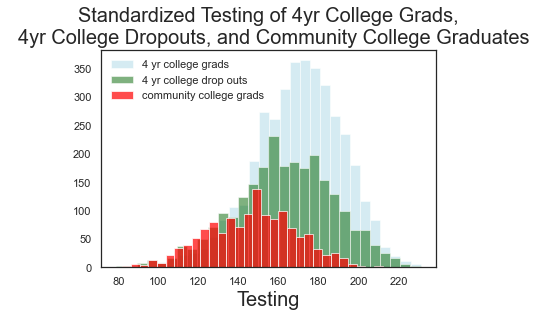

In [161]:
plt.hist(coll_y.testing, alpha=0.5, bins=30, color='lightblue')
plt.hist(coll_n.testing, alpha=0.5, bins=30, color='darkgreen')
plt.hist(comm_y.testing, alpha=.7, bins=30, color='red')

plt.title('Standardized Testing of 4yr College Grads,\n  4yr College Dropouts, and Community College Graduates', size = 20)
plt.xlabel('Testing', size = 20 )
plt.savefig('testing2.png', bbox_inches='tight')
plt.legend(['4 yr college grads', '4 yr college drop outs','community college grads'])
plt.show()

In [43]:
print(f'mean wages for 4yr college graduates: {round(coll_y.wages_cont.mean())}')
print(f'mean wages for 4yr college drop outs: {round(coll_n.wages_cont.mean())}')
print(f'mean wages for commmunity college graduates: {round(comm_y.wages_cont.mean())}')
print(f'mean wages for community college drop outs: {round(comm_n.wages_cont.mean())}')

mean wages for 4yr college graduates: 5897556.0
mean wages for 4yr college drop outs: 4054904.0
mean wages for commmunity college graduates: 3935624.0
mean wages for community college drop outs: 3093576.0


Negligible wage difference between 4yr college dropouts and community college graduates.  Note that the construct used here is 'wages_cont' and as such the values are not in dollars.

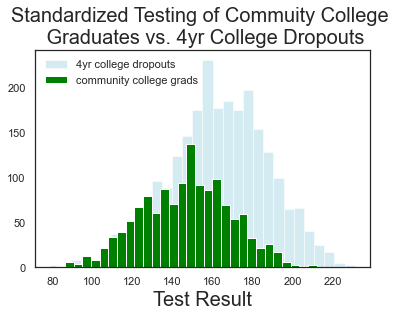

In [162]:
plt.hist(coll_n.testing, alpha=.5, bins=30, color='lightblue')
plt.hist(comm_y.testing, alpha=1, bins=30, color='green')
plt.title('Standardized Testing of Commuity College \n Graduates vs. 4yr College Dropouts',size = 20)
plt.xlabel('Test Result',size = 20)
plt.legend(['4yr college dropouts', 'community college grads'], loc = 2)
plt.savefig('testinghist2.png', bbox_inches='tight')
plt.show()

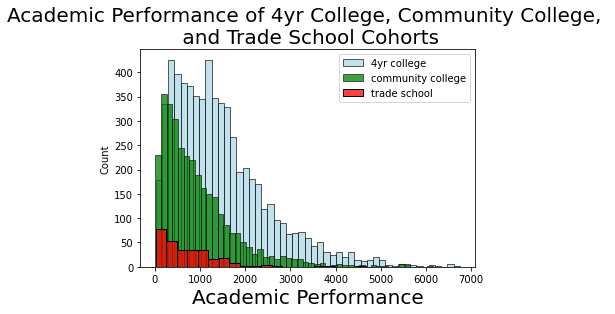

In [45]:
p = comm_t[(comm_t.academic_p > 0)]
q = coll_t[(coll_t.academic_p > 0)]
r = trade_t[(trade_t.academic_p > 0)]

sns.histplot(q['academic_p'],  color = 'lightblue', label='tot')
sns.histplot(p['academic_p'],  color = 'green',label='yes')
sns.histplot(r['academic_p'],  color = 'red',label='no')
plt.title('Academic Performance of 4yr College, Community College, \n and Trade School Cohorts',size = 20 )
plt.legend(['4yr college', 'community college','trade school'])
plt.xlabel('Academic Performance',size = 20)
plt.show()

The blue distributinon is the 4yr college cohort, the green distribution is the community college cohort, and the red distribution is the trade school group.  The academic performance construct is (homework time x high school academic load x high school GPA).

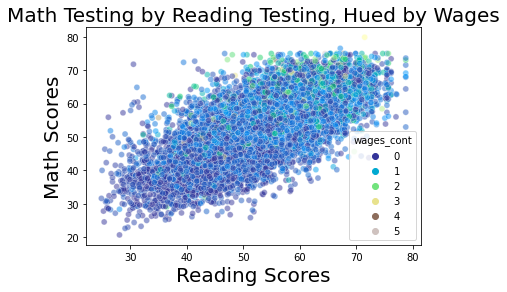

In [46]:
sns.scatterplot(x = 'reading_b', 
                y = 'math_1',
                data = exp,
                alpha = .5,
                hue = 'wages_cont',
                palette = 'terrain'           
               )
plt.title('Math Testing by Reading Testing, Hued by Wages', size = 20)
plt.xlabel('Reading Scores',size = 20)
plt.ylabel('Math Scores',size = 20)
plt.savefig('m&r_$.png', bbox_inches='tight')
plt.show()

Positive corellation between verbal and mathematical ability and wages.

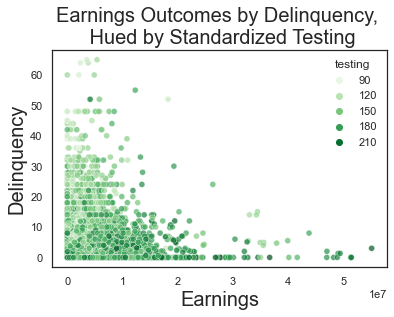

In [684]:
sns.scatterplot(x = 'wages_cont', 
                y = 'delinquency',
                data = exp,
                alpha = .7,
                hue = 'testing',
                palette = 'Greens'
               )
plt.xlabel('Earnings',size = 20)
plt.ylabel('Delinquency',size = 20)
plt.title('Earnings Outcomes by Delinquency, \n Hued by Standardized Testing',size = 20)
plt.savefig('del_wages.png', bbox_inches='tight')
plt.show()

L shaped character when plotted off of wages. Definite trade off between qualities in the 'delinquency' metric and future earnings. Note the hues. this graph is hued off the 'testing' metric, emphasizing the tradeoff between earnings and standardized testing.  Values on the 'delinquency' metric are vary inversely to earning potential. 'delinquency' is (hedonics_b + hedonics_1) x risk_factors

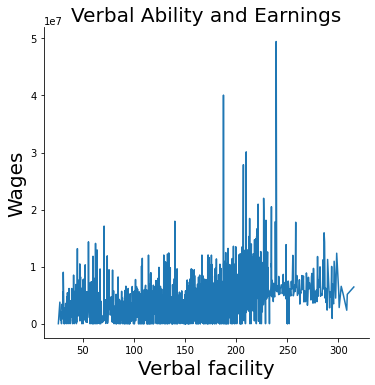

In [47]:
sns.relplot(x="v_facility", y="wages_cont", ci=None, kind="line", data=exp)
plt.title('Verbal Ability and Earnings',size = 20)
plt.xlabel('Verbal facility',size = 20)
plt.ylabel('Wages',size = 20)
plt.savefig('v_wages.png', bbox_inches='tight')
plt.show()

In [48]:
print(f'verbal facility mean {round(exp.v_facility.mean())}')
print(f'verbal facility standard deviation {round(exp.v_facility.std())}')

verbal facility mean 179.0
verbal facility standard deviation 56.0


Note the increase in wages when x-axis is mathematical reasoning  vs. the above graph where x-axis is a verbal reasoning metric.  Wages increase monotonically with math facility and peak and go down with verbal ability.  Perhaps this is visual demonstration of hyper-verbal individuals struggling to find a place in the job market.  In any event the point of dimishing returns for verbal facility appears to be at about 3/5 of a standard deviation above the mean.  There actually appears to a slight exponentiality at extreme ranges of mathematical ability as opposed to a the local peak in the verbal ability chart.

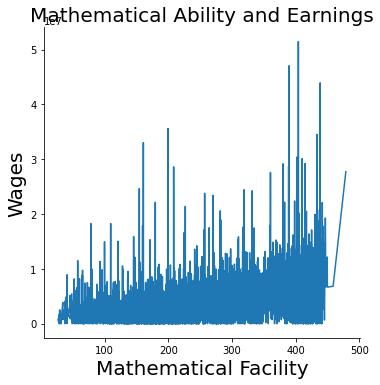

In [49]:
sns.relplot(x="m_facility", y="wages_cont", ci=None, kind="line", data=exp)
plt.title('Mathematical Ability and Earnings',size = 20)
plt.xlabel('Mathematical Facility',size = 20)
plt.ylabel('Wages',size = 20)
plt.savefig('m_wages.png', bbox_inches='tight')
plt.show()

In [52]:
def plotbar(x,y,data, save = False):
    sns.barplot(x = x,
            y = y,
            data = data,
            palette = 'Greens');
    if save == True:
        plt.savefig(f'{x}-{y}-{data}.png', bbox_inches='tight')  
    plt.style.use('seaborn-whitegrid')
    plt.title(f'{y} by {x}', size = 20)
    plt.xlabel(f'{x}',size = 20)
    plt.ylabel(f'{y}',size = 20)
    plt.show()
    return

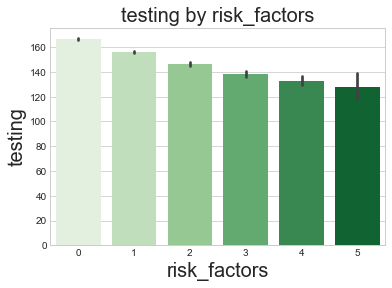

In [53]:
plotbar('risk_factors','testing',exp)

As risk factors increase standardized test scores decrease.

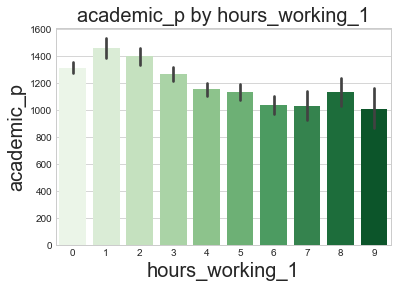

In [54]:
plotbar('hours_working_1','academic_p',exp)

High school 'academic performance' feature appears to trade off with hours worked.

## preprocessing

The modeling will classify 4yr college graduates from other educational outcomes.  As such i create a target column corresponding to this value.  Also dropping columns that will corrupt modelling.

In [55]:
#subsetting those that graduated from a 4yr college and those that did not in train set.  
imp_coll_4yr_train = train_college_imp[(train_college_imp.graduated_Y == 1) & (train_college_imp.ps_level == 1)]
imp_not_coll_train = train_college_imp[(train_college_imp.graduated_Y != 1) | (train_college_imp.ps_level != 1)]

#creating target column indicating 4yr college graduation status
imp_coll_4yr_train['target'] = 1
imp_not_coll_train['target'] = 0

#list of features to drop that will corrupt modelling
drop_list_2 = ['ps_level','wages_cont', 'graduated_Y']

#dropping features
drop_stuff(imp_coll_4yr_train,drop_list_2)
drop_stuff(imp_not_coll_train,drop_list_2)

#rejoining features of training dataset
imp_training = pd.concat([imp_coll_4yr_train,imp_not_coll_train])

/Users/eonjamesslemp/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/eonjamesslemp/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/eonjamesslemp/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/pandas/core/frame.py:4117: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in

Creating 'target' column along similiar lines to training set.  Also dropping columns that will corrupt modelling.

In [56]:
#subsetting those that graduated from a 4yr college and those that did not in test set.  
imp_coll_4yr_test = test_college_imp[(test_college_imp.graduated_Y == 1)&(test_college_imp.ps_level == 1)]
imp_not_coll_test = test_college_imp[(test_college_imp.graduated_Y != 1)|(test_college_imp.ps_level != 1)]

#creating target column indicating 4yr college graduation status
imp_coll_4yr_test['target'] = 1
imp_not_coll_test['target'] = 0

#dropping features from test set that would corrupt modelling
drop_stuff(imp_coll_4yr_test, drop_list_2)
drop_stuff(imp_not_coll_test, drop_list_2)

#rejoining features of training dataset
imp_testing = pd.concat([imp_coll_4yr_test,imp_not_coll_test])

/Users/eonjamesslemp/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/eonjamesslemp/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/eonjamesslemp/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/pandas/core/frame.py:4117: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in

A last bit of exploratory visualization now that 'target' has been defined in the dataset.

In [57]:
imp_training.describe()

,literacy_home,risk_factors,math_b,reading_b,math_conf_b,verbal_confidence,writing,sports,by_xcurr,homework,hedonics_b,hours_working_b,edu_confidence,math_1,math_status_1,f1_xcurr,hours_working_1,hedonics_1,math_conf_1,hs_ac_load,hs_gpa,effort,testing,v_facility,m_facility,academic_p,iq_by_concientiousness,delinquency,aspired_occ_b_-1,aspired_occ_b_1,aspired_occ_b_2,aspired_occ_b_3,aspired_occ_b_4,aspired_occ_b_5,aspired_occ_b_6,aspired_occ_b_7,aspired_occ_b_8,aspired_occ_b_9,aspired_occ_b_10,aspired_occ_b_11,aspired_occ_b_12,aspired_occ_b_13,aspired_occ_b_14,aspired_occ_b_15,aspired_occ_b_16,aspired_occ_b_17,aspired_occ_1_-1,aspired_occ_1_1,aspired_occ_1_2,aspired_occ_1_3,aspired_occ_1_4,aspired_occ_1_5,aspired_occ_1_6,aspired_occ_1_7,aspired_occ_1_8,aspired_occ_1_9,aspired_occ_1_10,aspired_occ_1_11,aspired_occ_1_12,aspired_occ_1_13,aspired_occ_1_14,aspired_occ_1_15,aspired_occ_1_16,aspired_occ_1_17,target
count,7920.000000,7920.000000,7920.000000,7920.000000,7920.00000,7920.000000,7920.000000,7920.000000,7920.000000,7920.000000,7920.000000,7920.000000,7920.000000,7920.000000,7920.000000,7920.000000,7920.000000,7920.000000,7920.000000,7920.000000,7920.000000,7920.000000,7920.000000,7920.000000,7920.000000,7920.000000,7920.000000,7920.000000,7920.000000,7920.000000,7920.000000,7920.000000,7920.000000,7920.000000,7920.000000,7920.000000,7920.000000,7920.000000,7920.000000,7920.000000,7920.000000,7920.000000,7920.000000,7920.000000,7920.000000,7920.000000,7920.000000,7920.000000,7920.000000,7920.000000,7920.000000,7920.000000,7920.000000,7920.000000,7920.000000,7920.000000,7920.000000,7920.000000,7920.000000,7920.000000,7920.000000,7920.000000,7920.000000,7920.000000,7920.000000
mean,2.308965,0.792298,53.124197,52.943163,0.10186,0.088699,0.252607,1.138889,1.161237,10.432449,3.322727,1.023359,6.490657,52.503432,5.309596,2.408965,2.824747,2.910354,0.051546,25.536490,4.379545,267.977083,158.574747,179.025500,284.101014,1242.480051,17108.687090,4.948207,0.280429,0.001641,0.014773,0.007071,0.016288,0.019066,0.050631,0.030051,0.021212,0.237247,0.221843,0.015909,0.015404,0.005177,0.014899,0.017803,0.026768,0.003788,0.284975,0.002399,0.020833,0.001136,0.002146,0.004798,0.034596,0.010732,0.005556,0.272096,0.174747,0.024369,0.021843,0.015404,0.034975,0.040152,0.046212,0.003030,0.387121
std,0.800221,0.895988,9.316385,9.335767,0.86407,0.841729,0.859645,1.215571,1.310930,7.215670,2.136198,1.622962,1.363817,9.622204,0.993149,1.837933,2.398403,1.796306,0.904738,3.900347,1.297373,186.750717,25.955988,55.243745,86.359244,1000.611370,6148.331021,6.406055,0.449237,0.040484,0.120650,0.083795,0.126588,0.136764,0.219258,0.170737,0.144100,0.425422,0.415513,0.125132,0.123161,0.071768,0.121156,0.132243,0.161414,0.061433,0.451431,0.048924,0.142835,0.033693,0.046283,0.069105,0.182766,0.103046,0.074333,0.445067,0.379775,0.154201,0.146181,0.123161,0.183727,0.196327,0.209957,0.054968,0.487123
min,0.000000,0.000000,19.380000,24.910000,-1.83100,-2.197000,-1.847000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,22.640000,1.000000,0.000000,0.000000,0.000000,-2.039000,6.000000,0.000000,0.000000,75.000000,26.140000,26.530000,0.000000,917.600000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,47.027500,46.720000,-0.52450,-0.453000,-0.221100,0.000000,0.000000,5.000000,2.000000,0.000000,6.000000,45.830000,5.000000,1.000000,0.000000,2.000000,-0.510000,24.000000,4.000000,125.000000,141.000000,145.710000,226.587500,482.250000,12928.677500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.

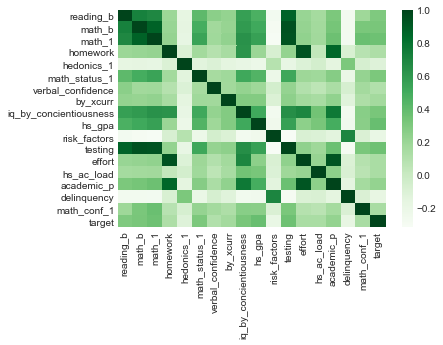

In [58]:
corr_features = imp_training[['reading_b','math_b','math_1','homework','hedonics_1',
                              'math_status_1','verbal_confidence','by_xcurr',
                              'iq_by_concientiousness','hs_gpa','risk_factors',
                              'testing','effort','hs_ac_load','academic_p','delinquency',
                              'math_conf_1','target']]

cor_matrix = corr_features.corr()

sns.heatmap(cor_matrix, cmap ='Greens')
plt.show()

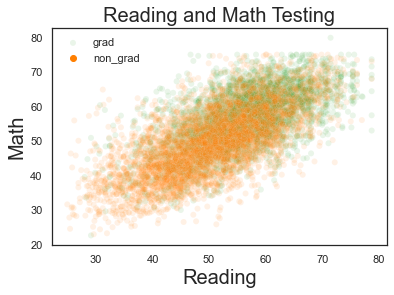

In [158]:
sns.scatterplot(x = 'reading_b', 
                y = 'math_1',
                data = imp_training,
                alpha = .1,
                hue = 'target',
                palette = 'Paired_r'           
               )

plt.title('Reading and Math Testing', size = 20)
plt.xlabel('Reading',size = 20)
plt.ylabel('Math',size = 20)
plt.legend(['grad','non_grad'])
sns.set(style = "white")
plt.savefig('m_r_conf.png', bbox_inches='tight')
plt.show()

Note how 4yr college graduates are at the extreme ends of the axes for verbal and mathematical ability.  Note the green hues on the upper surface of the plot.  That seems to suggest a slight bias towards mathematical ability with regard to college success.

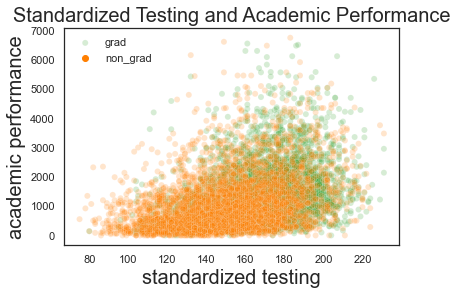

In [62]:
sns.scatterplot(x = 'testing', 
                y = 'academic_p',
                data = imp_training,
                alpha = .2,
                hue = 'target',
                palette = 'Paired_r'           
               )
plt.style.use('seaborn-whitegrid')
sns.set(style = "white")
#style.use('classic')
plt.title('Standardized Testing and Academic Performance', size = 20)
plt.xlabel('standardized testing',size = 20)
plt.ylabel('academic performance',size = 20)
plt.legend(['grad','non_grad'])
plt.savefig('test&performance.png', bbox_inches='tight')
plt.show()

Clear relationship between standardized testing and academic performanc.  

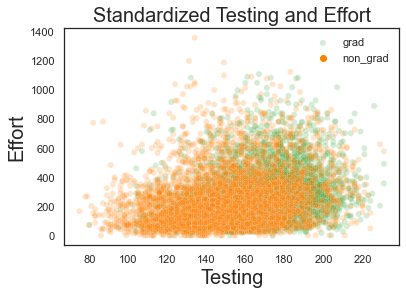

In [64]:
sns.scatterplot(x = 'testing', 
                y = 'effort',
                data = imp_training,
                alpha = .2,
                hue = 'target',
                palette = 'Paired_r'           
               )
plt.style.use('seaborn-whitegrid')
sns.set(style = "white")
#style.use('classic')
plt.title('Standardized Testing and Effort', size = 20)
plt.xlabel('Testing',size = 20)
plt.ylabel('Effort',size = 20)
plt.legend(['grad','non_grad'])
plt.savefig('test&effort.png', bbox_inches='tight')
plt.show()

'effort' is 'homework' x 'hs_ac_load'.  Not surprising that graduates of college tend to occur at the extremes of standardized testing and higher amounts of 'effort'.

/Users/eonjamesslemp/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning:

Requested projection is different from current axis projection, creating new axis with requested projection.

/Users/eonjamesslemp/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



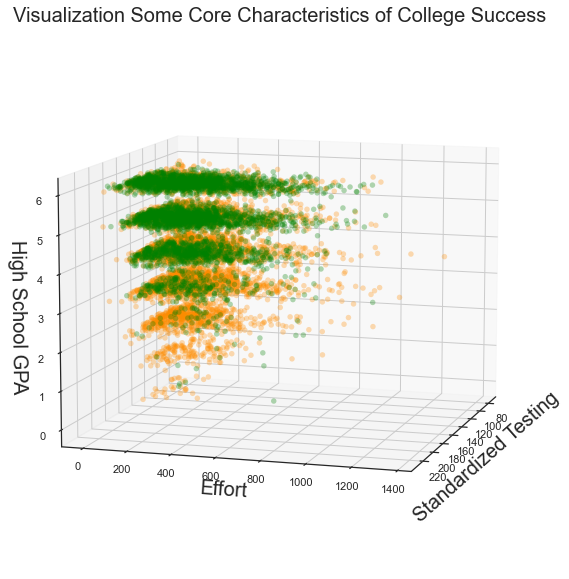

In [160]:
y_grad = exp[(exp.ps_level ==1) & (exp.graduated_Y == 1)]
n_grad = exp[(exp.ps_level !=1 ) | (exp.graduated_Y != 1)]

data = (y_grad, n_grad)
colors = ('green', 'darkorange')
groups = ('college grad', 'not grad') 

fig = plt.figure(figsize = (15, 10))

ax = fig.add_subplot(1, 1, 1)
ax = fig.gca(projection='3d')
# ax.set_proj_type('ortho')

for data, color, group in zip(data, colors, groups):
    x, y, z = data.testing, data.effort, data.hs_gpa
    ax.scatter(x, y, z, alpha=0.3, c=color, edgecolors='none', s=30, label=group)
# x, y, z = data.testing, data.effort, data.hs_ac_load
# ax.scatter(x, y, z, alpha=0.4, c=color, edgecolors='none', s=30, label=group)
ax.set_xlabel('Standardized Testing',size = 20)
ax.set_ylabel('Effort',size = 20)
ax.set_zlabel('High School GPA',size = 20)
plt.title('Visualization Some Core Characteristics of College Success',size = 20)
#plt.savefig('3dcharacteristics.png', bbox_inches='tight')
ax.view_init(10, 17)
plt.draw()
plt.pause(.001)

/Users/eonjamesslemp/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning:

Requested projection is different from current axis projection, creating new axis with requested projection.

/Users/eonjamesslemp/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



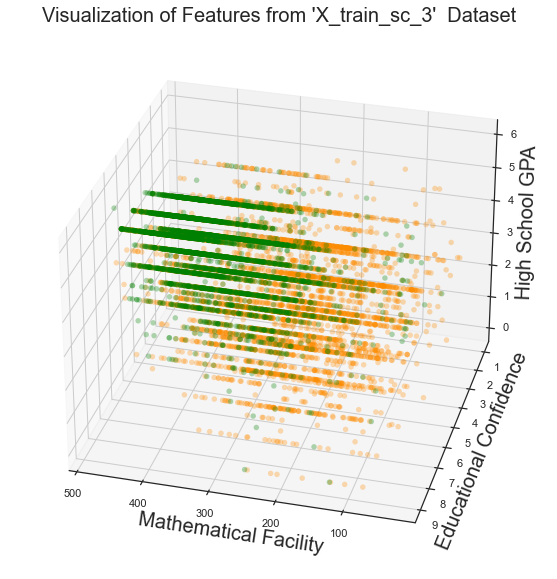

In [83]:
y_grad = exp[(exp.ps_level ==1) & (exp.graduated_Y == 1)]
n_grad = exp[(exp.ps_level !=1 ) | (exp.graduated_Y != 1)]

data = (y_grad, n_grad)
colors = ('green', 'darkorange')
groups = ('college grad', 'not grad') 

# Create plot
fig = plt.figure(figsize = (15, 10))

ax = fig.add_subplot(1, 1, 1)
ax = fig.gca(projection='3d')
# ax.set_proj_type('ortho')

for data, color, group in zip(data, colors, groups):
    x, y, z = data.m_facility, data.edu_confidence, data.hs_gpa
    ax.scatter(x, y, z, alpha=0.3, c=color, edgecolors='none', s=30, label=group)
# x, y, z = data.testing, data.effort, data.hs_ac_load
# ax.scatter(x, y, z, alpha=0.4, c=color, edgecolors='none', s=30, label=group)


ax.set_xlabel('Mathematical Facility',size = 20)
ax.set_ylabel('Educational Confidence',size = 20)
ax.set_zlabel('High School GPA',size = 20)
plt.title('Visualization of Features from \'X_train_sc_3\'  Dataset',size = 20)
   
ax.view_init(30, 105)
plt.draw()
plt.pause(.001)    
#plt.savefig('3d_X_train_sc_3.png', bbox_inches='tight')
# plt.ion()


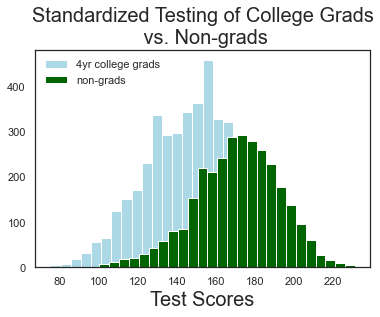

In [97]:
plt.hist(imp_not_coll_train.testing, alpha=1, bins=30, color='lightblue')
plt.hist(imp_coll_4yr_train.testing, alpha=1, bins=30, color='darkgreen')
plt.style.use('seaborn-ticks')
plt.title('Standardized Testing of College Grads\n vs. Non-grads',size = 20)
plt.xlabel('Test Scores',size = 20)
plt.legend(['4yr college grads','non-grads'], loc = 2)
sns.set(style = "white")
plt.savefig('testinghist3.png', bbox_inches='tight')

plt.show()

In [101]:
print(f'mean for entire study population {round(imp_training.testing.mean())}')
print(f'standard deviation for entire study population {round(imp_training.testing.std())}')
print(f'mean for non-college grads{round(imp_not_coll_train.testing.mean())}')
print(f'mean for college grads{round(imp_coll_4yr_train.testing.mean())}')

mean for entire study population 159.0
standard deviation for entire study population 26.0
mean for non-college grads151.0
mean for college grads170.0


Almost a standard deviation difference on average between graduates of a 4yr college and non-graduates

Math ability critical for higher academic credentialing

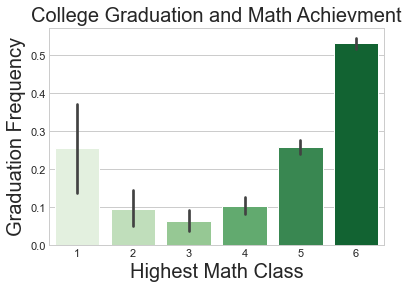

In [277]:
sns.barplot(x = 'math_status_1',
            y = 'target',
            data = imp_training,
            palette = 'Greens')
plt.title('College Graduation and Math Achievment', size = 20)
plt.xlabel('Highest Math Class',size = 20)
plt.ylabel('Graduation Frequency',size = 20)
plt.savefig('math_bar.png', bbox_inches='tight')
plt.show()

Math ability related to college success

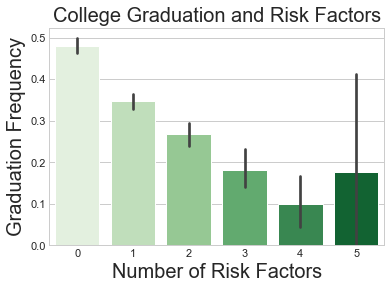

In [278]:
sns.barplot(x = 'risk_factors',
            y = 'target',
            data = imp_training,
            palette = 'Greens')
plt.title('College Graduation and Risk Factors', size = 20)
plt.xlabel('Number of Risk Factors',size = 20)
plt.ylabel('Graduation Frequency',size = 20)
plt.savefig('risk_bar.png', bbox_inches='tight')
plt.show()


Risk factors like poverty, frequent school relocations, or broken familiy structure negatively correlated with college graduation.

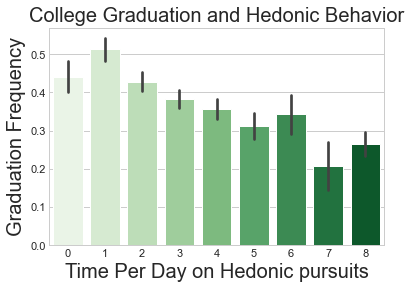

In [103]:
sns.barplot(x = 'hedonics_b',
            y = 'target',
            data = imp_training,
            palette = 'Greens')
plt.title('College Graduation and Hedonic Behavior', size = 20)
plt.xlabel('Time Per Day on Hedonic pursuits',size = 20)
plt.ylabel('Graduation Frequency',size = 20)
plt.savefig('risk_bar.png', bbox_inches='tight')
plt.show()

Not as dramatic but still negative correlation between hedonic behavior and college graduation.  Higher entertainment time allocation is related to diminished 4yr college graduation rates.

### Parsing Datasets for Modelling

In [105]:
imp_training_y = imp_training.target
imp_training_x = imp_training.drop(columns = 'target', axis = 1)

In [106]:
imp_testing_y = imp_testing.target
imp_testing_x = imp_testing.drop(columns = 'target', axis = 1)

In [107]:
imp_training_x.head(1)

,literacy_home,risk_factors,math_b,reading_b,math_conf_b,verbal_confidence,writing,sports,by_xcurr,homework,hedonics_b,hours_working_b,edu_confidence,math_1,math_status_1,f1_xcurr,hours_working_1,hedonics_1,math_conf_1,hs_ac_load,hs_gpa,effort,testing,v_facility,m_facility,academic_p,iq_by_concientiousness,delinquency,aspired_occ_b_-1,aspired_occ_b_1,aspired_occ_b_2,aspired_occ_b_3,aspired_occ_b_4,aspired_occ_b_5,aspired_occ_b_6,aspired_occ_b_7,aspired_occ_b_8,aspired_occ_b_9,aspired_occ_b_10,aspired_occ_b_11,aspired_occ_b_12,aspired_occ_b_13,aspired_occ_b_14,aspired_occ_b_15,aspired_occ_b_16,aspired_occ_b_17,aspired_occ_1_-1,aspired_occ_1_1,aspired_occ_1_2,aspired_occ_1_3,aspired_occ_1_4,aspired_occ_1_5,aspired_occ_1_6,aspired_occ_1_7,aspired_occ_1_8,aspired_occ_1_9,aspired_occ_1_10,aspired_occ_1_11,aspired_occ_1_12,aspired_occ_1_13,aspired_occ_1_14,aspired_occ_1_15,aspired_occ_1_16,aspired_occ_1_17
0,3,1,64.65,65.7,0.7487,0.5229,0.052,0,1,10,1,0,7,65.65,6,3,3,1,0.9824,32,6,320.0,196,262.8,393.9,1920,27581.4,2.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


#### 15 best features by select kbest

In [108]:
selector = SelectKBest(f_classif, k=15) 

selector.fit(imp_training_x, imp_training_y)

selected_columns = imp_training_x.columns[selector.get_support()]
removed_columns = imp_training_x.columns[~selector.get_support()]

X_train_kb15 = imp_training_x[selected_columns]
X_test_kb15 = imp_testing_x[selected_columns]
print(X_train_kb15.shape, X_test_kb15.shape)

(7920, 15) (1981, 15)


#### 20 best features by select kbest

In [109]:
selector = SelectKBest(f_classif, k=20) 

selector.fit(imp_training_x, imp_training_y)

selected_columns = imp_training_x.columns[selector.get_support()]
removed_columns = imp_training_x.columns[~selector.get_support()]

X_train_kb20 = imp_training_x[selected_columns]
X_test_kb20 = imp_testing_x[selected_columns]
print(X_train_kb20.shape, X_test_kb20.shape)

(7920, 20) (1981, 20)


#### 25 best features by select kbest

In [110]:
selector = SelectKBest(f_classif, k=25) 

selector.fit(imp_training_x, imp_training_y)

selected_columns = imp_training_x.columns[selector.get_support()]
removed_columns = imp_training_x.columns[~selector.get_support()]

X_train_kb25 = imp_training_x[selected_columns]
X_test_kb25 = imp_testing_x[selected_columns]
print(X_train_kb25.shape, X_test_kb25.shape)

(7920, 25) (1981, 25)


#### highly feature inclusive scaled dataset

In [111]:
scaler = StandardScaler()
scaler.fit(imp_training_x)

X_train_sc = scaler.transform(imp_training_x)
X_test_sc = scaler.transform(imp_testing_x)

In [112]:
X_train_sc = pd.DataFrame(X_train_sc)
X_test_sc = pd.DataFrame(X_test_sc)

In [113]:
rename_cols = imp_training_x.columns
old_cols = X_train_sc.columns
rename_dict = dict(zip(old_cols,rename_cols))

#print(zip_rename)

X_train_sc.rename(columns = rename_dict, inplace = True)
X_test_sc.rename(columns = rename_dict, inplace = True)
# X_train_sc.head()

In [114]:
keep_20 = X_train_kb20.columns
X_train_sc_20 = X_train_sc.loc[:,keep_20]
X_test_sc_20 = X_test_sc.loc[:,keep_20]

In [115]:
keep_15 = X_train_kb15.columns
X_train_sc_15 = X_train_sc.loc[:,keep_15]
X_test_sc_15 = X_test_sc.loc[:,keep_15]

In [116]:
keep_3 =  ['hs_gpa', 'm_facility', 'edu_confidence' ]
X_train_sc_3 = X_train_sc.loc[:,keep_3]
X_test_sc_3 = X_test_sc.loc[:,keep_3]

In [117]:
X_train_sc.shape


(7920, 64)

model evaluation function

In [118]:
def evaluate(test, pred):    
    #prints four performance metrics
    print('Accuracy: ', round(accuracy_score(test, pred),4))
    print('F1: ', round(f1_score(test, pred),4))
    print('Recall: ', round(recall_score(test, pred),4))
    print('precision: ', round(precision_score(test,pred),4))
    
    #displays confusion matrix
    plt.style.use('seaborn-ticks')
    cm = confusion_matrix(imp_testing_y, pred)
    ConfusionMatrixDisplay(cm).plot()   
    
    #print(f'confusion matrix: \n {confusion_matrix(imp_testing_y, pred)}')
        
    return 

ROC curve function

In [119]:
def ROC(test_x, model,save = False):
    #prints an ROC curve
    y_pred_prob = model.predict_proba(test_x)[:, 1]

    fpr, tpr, thresholds = metrics.roc_curve(imp_testing_y, y_pred_prob)
    plt.plot(fpr, tpr)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.title(f'ROC curve for {model}')
    plt.xlabel('false positive rate FP/(TN+TP) ')
    plt.ylabel('true positive rate TP/(TP +FN)')
    plt.style.use('seaborn-colorblind')
    plt.grid(True)
    if save == True:
        plt.savefig('roclr.png', bbox_inches='tight')
    return

## Modeling - performance

#### Random Forest 

Accuracy:  0.6875
F1:  0.6167
Recall:  0.6304
precision:  0.6036


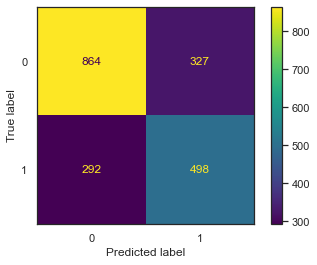

In [120]:
rf = RandomForestClassifier(n_estimators=140,  max_depth = 8, min_samples_split = 4, oob_score=True, random_state=13)
rf.fit(X_train_kb20, imp_training_y)

predicted_rf = rf.predict(X_test_kb20)

evaluate(imp_testing_y,predicted_rf)

In [121]:
probs_rf = rf.predict_proba(X_test_kb20)[:, 1]
precision_rf, recall_rf, _ = precision_recall_curve(imp_testing_y, probs_rf)
auc_rf = auc(recall_rf, precision_rf)

#### Logistic Regression

Accuracy:  0.6896
F1:  0.5946
Recall:  0.5709
precision:  0.6204


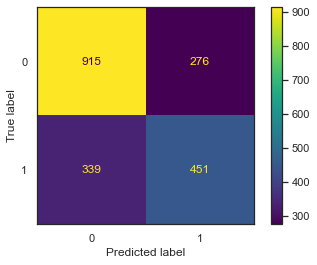

In [122]:
lr = LogisticRegression(penalty = 'l1',solver='liblinear', max_iter = 60,random_state=13, C=1,)
lr.fit(X_train_sc_15, imp_training_y)

predict_lr = lr.predict(X_test_sc_15)

evaluate(imp_testing_y,predict_lr)

In [123]:
probs_lr = lr.predict_proba(X_test_sc_15)[:, 1]
precision_lr, recall_lr, _ = precision_recall_curve(imp_testing_y, probs_lr)
auc_lr = auc(recall_lr, precision_lr)

#### XGBoost 

Accuracy:  0.6855
F1:  0.6142
Recall:  0.6278
precision:  0.6012


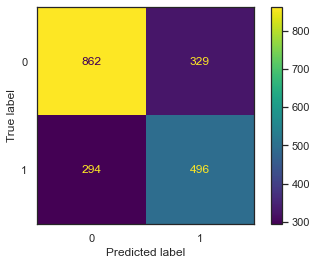

In [124]:
xgb = XGBClassifier(max_depth = 2, n_estimators = 90, gamma = .2,
            min_child_weight = 6, subsample = .9, colsample_bytree = .7,)
xgb.fit(X_train_kb20,imp_training_y)

predict_xgb = xgb.predict(X_test_kb20)
 
evaluate(imp_testing_y,predict_xgb)

In [125]:
probs_xgb = xgb.predict_proba(X_test_kb20)[:, 1]
precision_xgb, recall_xgb, _ = precision_recall_curve(imp_testing_y, probs_xgb)
auc_xgb = auc(recall_xgb, precision_xgb)

#### Gaussian Naive Bayes

Accuracy:  0.6835
F1:  0.6511
Recall:  0.7405
precision:  0.5809


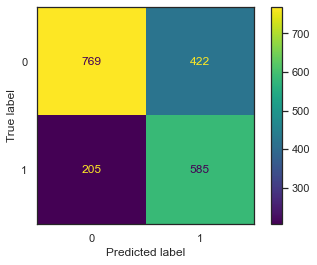

In [126]:
gnb = GaussianNB()

gnb.fit(X_train_sc_3,imp_training_y)

predict_gnb = gnb.predict(X_test_sc_3)

evaluate(imp_testing_y,predict_gnb)

best recall and F1 metrics from any modelling was from gaussian naive bayes

In [127]:
probs_gnb= gnb.predict_proba(X_test_sc_3)[:, 1]
precision_gnb, recall_gnb, _ = precision_recall_curve(imp_testing_y, probs_gnb)
auc_gnb = auc(recall_gnb, precision_gnb)

#### KNN

Accuracy:  0.6825
F1:  0.6227
Recall:  0.657
precision:  0.5918


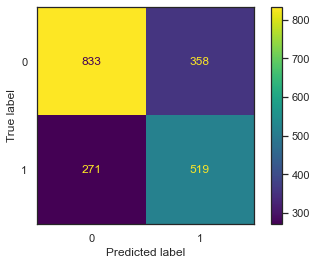

In [128]:
knn = KNeighborsClassifier(n_neighbors = 110, leaf_size = 1, p = 3)

knn.fit(X_train_sc_20,imp_training_y)

predict_knn = knn.predict(X_test_sc_20)

evaluate(imp_testing_y,predict_knn)

In [129]:
probs_knn = knn.predict_proba(X_test_sc_20)[:, 1]
precision_knn, recall_knn, _ = precision_recall_curve(imp_testing_y, probs_knn)
auc_knn = auc(recall_knn, precision_knn)

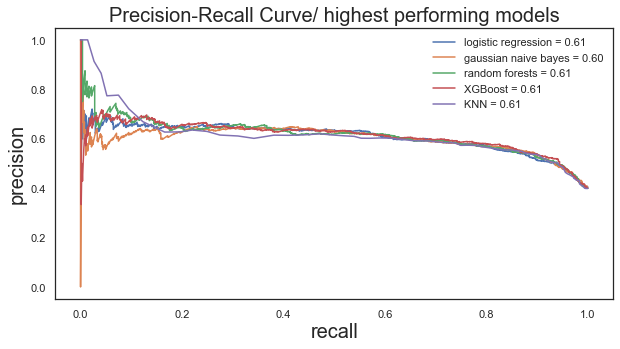

In [130]:
plt.figure(figsize=(10, 5))
plt.plot(recall_lr, precision_lr, label=f'logistic regression = {auc_lr:.2f}')
plt.plot(recall_gnb, precision_gnb, label=f'gaussian naive bayes = {auc_gnb:.2f}')
plt.plot(recall_rf, precision_rf, label=f'random forests = {auc_rf:.2f}')
plt.plot(recall_xgb, precision_xgb, label=f'XGBoost = {auc_xgb:.2f}')
plt.plot(recall_knn, precision_knn, label=f'KNN = {auc_knn:.2f}')
plt.title('Precision-Recall Curve/ highest performing models', size=20)
plt.xlabel('recall', size=20)
plt.ylabel('precision', size=20)
#plt.style.use('fast')
plt.savefig('p_r_per.png', bbox_inches='tight')
plt.legend();

Recall/percision trade off comparable accross models.

## Modeling - 3 feature models

the following models provided the best precision (false positive) to recall (false negative) rates with the most restricted data sets.  

#### Random Forest 

Accuracy:  0.6855
F1:  0.6217
Recall:  0.6481
precision:  0.5974


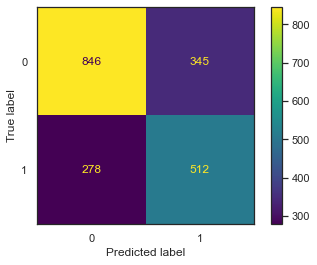

In [131]:
rf = RandomForestClassifier(n_estimators=140,  max_depth = 8, min_samples_split = 4, random_state=13, bootstrap = False)
rf.fit(X_train_sc_3, imp_training_y)

predicted_rf = rf.predict(X_test_sc_3)

evaluate(imp_testing_y,predicted_rf)

In [132]:
probs_rf = rf.predict_proba(X_test_sc_3)[:, 1]
precision_rf, recall_rf, _ = precision_recall_curve(imp_testing_y, probs_rf)
auc_rf = auc(recall_rf, precision_rf)

#### Logistic Regression 

Accuracy:  0.6865
F1:  0.5868
Recall:  0.5582
precision:  0.6185


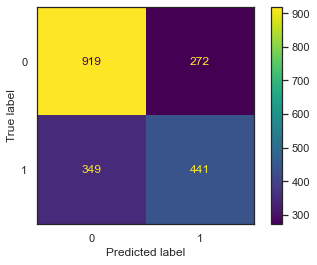

In [133]:
lr = LogisticRegression(penalty = 'l1',solver='liblinear', max_iter = 175,random_state=13, C=1,)
lr.fit(X_train_sc_3, imp_training_y)

predict_lr = lr.predict(X_test_sc_3)

evaluate(imp_testing_y,predict_lr)

In [134]:
probs_lr = lr.predict_proba(X_test_sc_3)[:, 1]
precision_lr, recall_lr, _ = precision_recall_curve(imp_testing_y, probs_lr)
auc_lr = auc(recall_lr, precision_lr)

#### XGBoost 

Accuracy:  0.6875
F1:  0.6162
Recall:  0.6291
precision:  0.6039


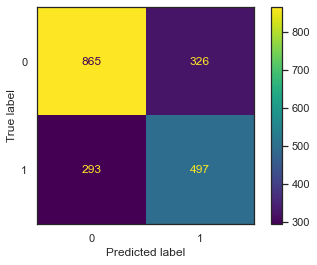

In [135]:
xgb = XGBClassifier(max_depth = 2, n_estimators = 90, gamma = .2,
            min_child_weight = 6, subsample = .9, colsample_bytree = .7,)
xgb.fit(X_train_sc_3,imp_training_y)

predict_xgb = xgb.predict(X_test_sc_3)
 
evaluate(imp_testing_y,predict_xgb)

In [136]:
probs_xgb = xgb.predict_proba(X_test_sc_3)[:, 1]
precision_xgb, recall_xgb, _ = precision_recall_curve(imp_testing_y, probs_xgb)
auc_xgb = auc(recall_xgb, precision_xgb)

Accuracy:  0.6835
F1:  0.6511
Recall:  0.7405
precision:  0.5809


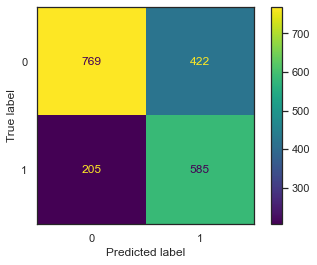

In [137]:
gnb = GaussianNB()

gnb.fit(X_train_sc_3,imp_training_y)

predict_nb = gnb.predict(X_test_sc_3)

evaluate(imp_testing_y,predict_gnb)

In [138]:
probs_gnb= gnb.predict_proba(X_test_sc_3)[:, 1]
precision_gnb, recall_gnb, _ = precision_recall_curve(imp_testing_y, probs_gnb)
auc_gnb = auc(recall_gnb, precision_gnb)

Accuracy:  0.6784
F1:  0.6001
Recall:  0.6051
precision:  0.5953


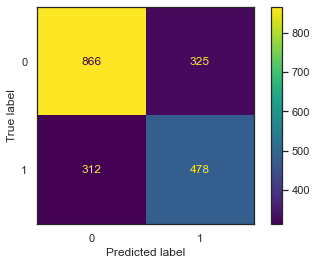

In [139]:
knn = KNeighborsClassifier(n_neighbors = 110, leaf_size = 1, p = 3)

knn.fit(X_train_sc_3,imp_training_y)

predict_knn = knn.predict(X_test_sc_3)

evaluate(imp_testing_y,predict_knn)

In [140]:
probs_knn = knn.predict_proba(X_test_sc_3)[:, 1]
precision_knn, recall_knn, _ = precision_recall_curve(imp_testing_y, probs_knn)
auc_knn = auc(recall_knn, precision_knn)

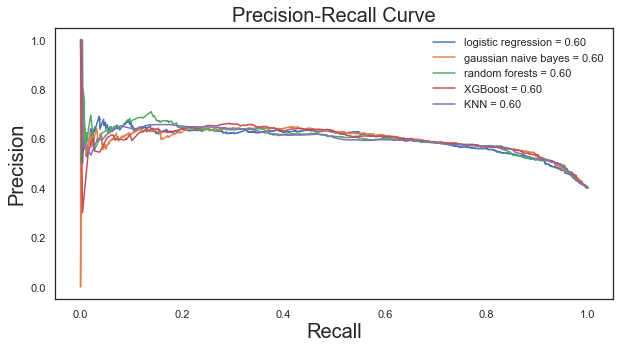

In [141]:
plt.figure(figsize=(10, 5))
plt.plot(recall_lr, precision_lr, label=f'logistic regression = {auc_lr:.2f}')
plt.plot(recall_gnb, precision_gnb, label=f'gaussian naive bayes = {auc_gnb:.2f}')
plt.plot(recall_rf, precision_rf, label=f'random forests = {auc_rf:.2f}')
plt.plot(recall_xgb, precision_xgb, label=f'XGBoost = {auc_xgb:.2f}')
plt.plot(recall_knn, precision_knn, label=f'KNN = {auc_knn:.2f}')
plt.title('Precision-Recall Curve', size=20)
plt.xlabel('Recall', size=20)
plt.ylabel('Precision', size=20)
plt.legend();

these models provided the best predictions with negligible loss of performance.  The features contained in these sets are:

## Best Model - Gaussian Naive Bayes with 'X_train_sc_3' data

Accuracy:  0.6835
F1:  0.6511
Recall:  0.7405
precision:  0.5809


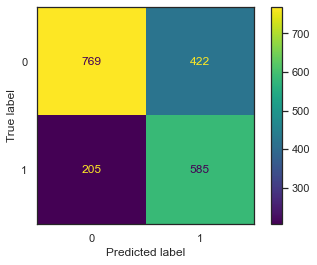

In [144]:
gnb = GaussianNB()

gnb.fit(X_train_sc_3,imp_training_y)

predict_nb = gnb.predict(X_test_sc_3)

evaluate(imp_testing_y,predict_gnb)

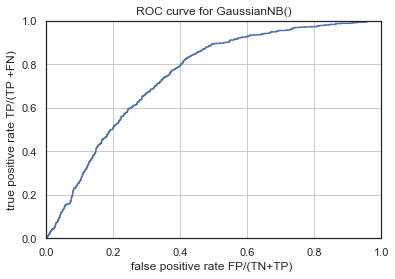

In [146]:
ROC(X_test_sc_3, gnb)

In [142]:
X_train_sc_3.columns

Index(['hs_gpa', 'm_facility', 'edu_confidence'], dtype='object')

Using models with fewer features provides insight into what is most important for correct classfiication and ultimate college performance.  The gaussian naive bayes algorithm with the 'X_train_sc_3' yielded a recall of .7405 and an F1 .6511.  This dataset's features are the mathematical facility construct, high school GPA, and educational confidence.   The following scatterplot is not composed with this dataset.  I used a slightly different set here because there are two ordinal features in 'X_train_sc_3'.  Two stratified ordinals is hard to get a sensible look at the target subset.  

/Users/eonjamesslemp/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning:

Requested projection is different from current axis projection, creating new axis with requested projection.

/Users/eonjamesslemp/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



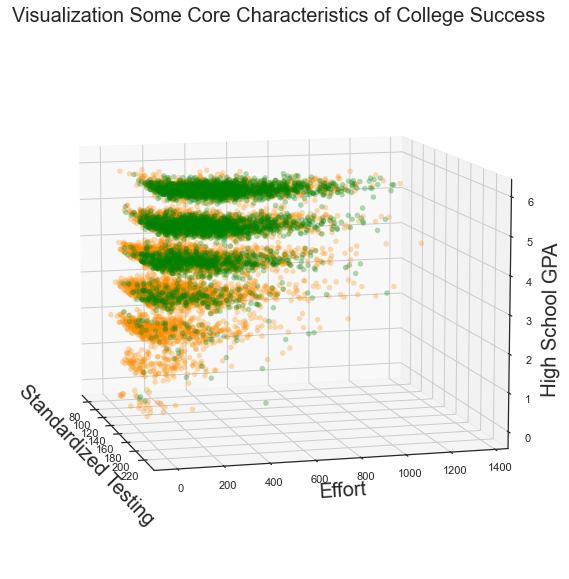

In [156]:
y_grad = exp[(exp.ps_level ==1) & (exp.graduated_Y == 1)]
n_grad = exp[(exp.ps_level !=1 ) | (exp.graduated_Y != 1)]

data = (y_grad, n_grad)
colors = ('green', 'darkorange')
groups = ('college grad', 'not grad') 

fig = plt.figure(figsize = (15, 10))

ax = fig.add_subplot(1, 1, 1)
ax = fig.gca(projection='3d')
# ax.set_proj_type('ortho')

for data, color, group in zip(data, colors, groups):
    x, y, z = data.testing, data.effort, data.hs_gpa
    ax.scatter(x, y, z, alpha=0.3, c=color, edgecolors='none', s=30, label=group)
# x, y, z = data.testing, data.effort, data.hs_ac_load
# ax.scatter(x, y, z, alpha=0.4, c=color, edgecolors='none', s=30, label=group)
ax.set_xlabel('Standardized Testing',size = 20)
ax.set_ylabel('Effort',size = 20)
ax.set_zlabel('High School GPA',size = 20)
plt.title('Visualization of Some Core Characteristics of College Success',size = 20)
#plt.savefig('3dcharacteristics.png', bbox_inches='tight')
ax.view_init(10, 345)
plt.draw()
plt.pause(.001)

The above graph is a visualization of what the 3 primary traits that this analysis concludes are critical for correctly discriminating a college graduate from a non-college gradaute using only data available in high schoool.

### Conclusions

This study reveals that what may seem obvious.  Succesfull college students have verbal and mathematical standardized testing scores that are, on average 1 standard deviation or more above thier peers. Specifically, mathematical reasoning ability gives the student an particular advantage in completing a college degree.. They are disciplined, in that they control hedonic pursuits and invest time outside of class on homework.  They tend to come from a home environment that is low in risk factors like broken family structure, frequent changes in school, or poverty.  
I believe that f1 score is the most usefull metric with regard to the modelling outcomes. F1 strikes a balance between recall and precision.  Recall minizes students excluded from college thus maximizing dropout rates.  Conversely, using the precision metric would recommend the strictest controls on college admissions and thus minimize dropout rate; although, my analysis at this point cannot support some claims I am about to make, my intuition tells me that college enrollments are too high when considered in light of the actual return on investment that the student can hope to get from the aspired credential.  To what degree colleges are not simply selecting for the cognitive elite is not clear.  Highly capable students may be able to find thier way in the economy quite succesfully without a college degree.  In other words, it may be that the opportunity cost of college is not always positive for many students that graduate succesfully.  Precision, with its narrowing of the window for recommended college enrollment might be the best metric.  To support this claim I have to do further analysis.  At this point I recommend F1 score as the performance metric of choice.
As far a use cases there may be an arguement that precision, recall and F1 can each be useful to different decision makers.  From the student's perspective, precision might be the prefered metric.  Precision will offer the most protection for the students investment of opportunity cost of a post-secondary adventure.  Precision provides the student the most conservative assesment of benefit.  
Guidance counselors might gravitate to F1 for advising purposes.  F1, considered in light of costs associated with college enrollment and likelihood of success can provide a more balanced assesment benefit. F1 score strikes a balance between the exclusion of precision and the permissivity of recall.  A college admission team would likely prefer recall, as recall will favor the institution's business considerations. 

### Next steps

**Dashboard deployemnt** - build an interface that can take data and return a probablity of college success <br>
**ROI** - Build out a further model of college return-on-investment. I am still working out how to do this. First thoughts are to subset the college graduate class and use the wage data to compare income to a non-college graduates with similiar data profile. Subtract the two and the use the 'time to graduation' data to estimate total cost of college. subtract this from the first caclulation and categorize negative values as negative or positive ROI. Then put the classifier to work predicting postive or negative ROI for that student based on just the high school data.<br>
**Neural Network** - Build a neural network for this classification task.<br>